<a href="https://colab.research.google.com/github/DivyanshRana1515/DL_Lab_500121856_Divyansh/blob/main/Exp_13_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)

BUFFER_SIZE = 60000
BATCH_SIZE = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# Generator model
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, input_shape=(100,)),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')
    ])
    return model

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

generator = build_generator()
discriminator = build_discriminator()
cross_entropy = tf.keras.losses.BinaryCrossentropy()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [4]:
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

@tf.function
def training_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated, training=True)

        g_loss = generator_loss(fake_output)
        d_loss = discriminator_loss(real_output, fake_output)

    grads_g = gen_tape.gradient(g_loss, generator.trainable_variables)
    grads_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    gen_opt.apply_gradients(zip(grads_g, generator.trainable_variables))
    disc_opt.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    return g_loss, d_loss

In [5]:
import time

EPOCHS = 3
for epoch in range(EPOCHS):
    start = time.time()
    g_losses, d_losses = [], []

    for img_batch in dataset:
        g_loss, d_loss = training_step(img_batch)
        g_losses.append(float(g_loss))
        d_losses.append(float(d_loss))

    print(f'Epoch {epoch+1}, Generator Loss: {np.mean(g_losses)}, Discriminator Loss: {np.mean(d_losses)}')

Epoch 1, Generator Loss: 1.1210537138524086, Discriminator Loss: 0.8465436271576485
Epoch 2, Generator Loss: 0.8042814176219867, Discriminator Loss: 1.148788589912691
Epoch 3, Generator Loss: 0.8492050480995097, Discriminator Loss: 1.2171286861779593


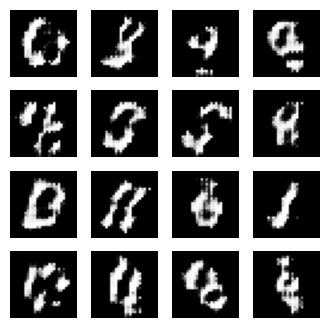

In [6]:
# Evaluation: Generate samples
def generate_images(n=16):
    noise = tf.random.normal([n, 100])
    preds = generator(noise, training=False)
    preds = preds.numpy().squeeze()

    plt.figure(figsize=(4,4))
    for i in range(n):
        plt.subplot(4,4,i+1)
        plt.imshow(preds[i], cmap='gray')
        plt.axis('off')
    plt.show()

generate_images(16)